/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification accuracy Single Best = 0.774
Classification accuracy Static Selection = 0.824


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Classification accuracy Stacked = 0.836
Classification accuracy KNORA-U = 0.846
Classification accuracy KNORA-E = 0.828
Classification accuracy OLA = 0.808
Classification accuracy LCA = 0.75
Classification accuracy MCB = 0.796
Classification accuracy META-DES = 0.84


<ipython-input-1-644004c941ae>:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Dark2')


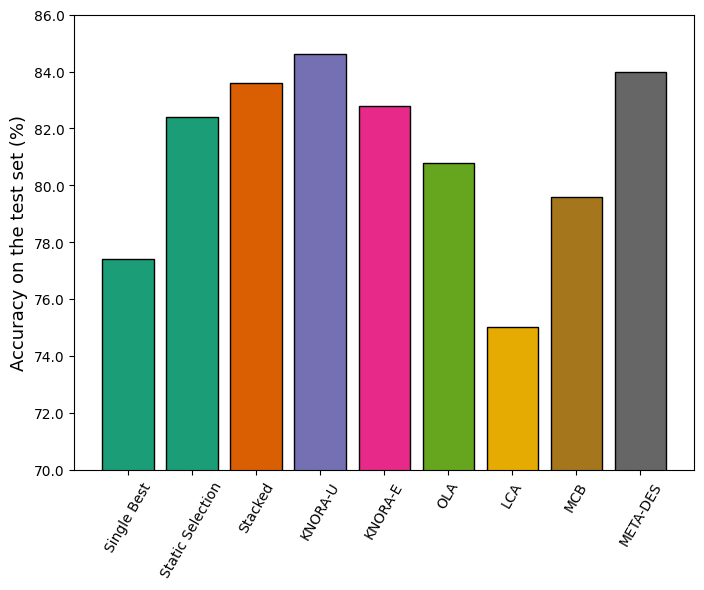

Oracle result: 0.994


In [ ]:
# coding=utf-8

# Author: Rafael Menelau Oliveira e Cruz <rafaelmenelau@gmail.com>
#
# License: BSD 3 clause
"""
====================================================================
Comparing dynamic selection with baseline static methods
====================================================================
In this example we compare the performance of DS techinques with the
static ensemble methods. DESlib offer the implementation of static ensemble
methods in the `deslib.static` module. The following techniques are
considered:
Static methods used as baseline comparison are in the `deslib.static` module.
They are:
**Majority Voting**: The outputs of all base classifiers in the pool are combined
using the majority voting rule
**Static Selection**: A fraction of the best performing classifiers (based on the
validation data, is selected to compose the ensemble).
**Single Best**: The base classifier with the highest classification accuracy in
the validation set is selected for classification
**Stacked classifier**: The outputs of all base classifiers are passed down to
a meta-estimator which combines them . The meta-estimator is trained based
on the outputs of the base classifiers on the training data.
These techniques are used in the dynamic selection literature as a baseline
comparison (for more information see references [1] and [2])
At the end we also present the result of the **Oracle**, which is an abastract
model which always selects the base classifier that predicted the correct label
if such classifier exists. From the dynamic selection point of view, the Oracle
is seen as the upper limit performance that can be achieved with the given
pool of classifiers.
References
----------
[1] Britto, Alceu S., Robert Sabourin, and Luiz ES Oliveira. "Dynamic selection
of classifiers—a comprehensive review." Pattern Recognition 47.11
(2014): 3665-3680.
[2] R. M. O. Cruz, R. Sabourin, and G. D. Cavalcanti, “Dynamic classifier
selection: Recent advances and perspectives,” Information Fusion,
vol. 41, pp. 195 – 216, 2018.
[3] Kuncheva, Ludmila I. "A theoretical study on six classifier fusion
    strategies." IEEE Transactions on Pattern Analysis & Machine Intelligence,
    (2002): 281-286.
"""

!pip install deslib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Example of dcs techniques
from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.dcs import LCA

# Example of des techniques
from deslib.des import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des import METADES

# For comparisons
from deslib.static import (StackedClassifier,
                           SingleBest,
                           StaticSelection,
                           Oracle)

rng = np.random.RandomState(123)

# Generate a classification dataset
X, y = make_classification(n_samples=2000,
                           n_classes=3,
                           n_informative=6,
                           random_state=rng)

# split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=rng)

X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train,
                                                    test_size=0.50,
                                                    random_state=rng)
from sklearn.ensemble import RandomForestClassifier
pool_classifiers = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=30, random_state=rng)
#pool_classifiers = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=46)
pool_classifiers.fit(X_train, y_train)

# Setting up static methods.
stacked = StackedClassifier(pool_classifiers)
static_selection = StaticSelection(pool_classifiers)
single_best = SingleBest(pool_classifiers)

# Initialize a DS technique. Here we specify the size of
# the region of competence (7 neighbors)
knorau = KNORAU(pool_classifiers, random_state=rng)
kne = KNORAE(pool_classifiers, random_state=rng)
ola = OLA(pool_classifiers, random_state=rng)
lca = LCA(pool_classifiers, random_state=rng)
mcb = MCB(pool_classifiers, random_state=rng)
meta = METADES(pool_classifiers, random_state=rng)

names = ['Single Best', 'Static Selection', 'Stacked',
         'KNORA-U', 'KNORA-E', 'OLA', 'LCA','MCB', 'META-DES']

methods = [single_best, static_selection, stacked,
           knorau, kne, ola, lca, mcb, meta]

# Fit the DS techniques
scores = []
for method, name in zip(methods, names):
    method.fit(X_dsel, y_dsel)
    scores.append(method.score(X_test, y_test))
    print("Classification accuracy {} = {}"
          .format(name, method.score(X_test, y_test)))


###############################################################################
# Plotting the results
# -----------------------
# Let's now evaluate the methods on the test set.
#
cmap = get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, ax = plt.subplots(figsize=(8, 6.5))
pct_formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x * 100))
ax.bar(np.arange(len(methods)),
       scores,
       color=colors,
       tick_label=names,
       edgecolor='k')

ax.set_ylim(0.70, 0.86)
ax.set_ylabel('Accuracy on the test set (%)', fontsize=13)
ax.yaxis.set_major_formatter(pct_formatter)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.subplots_adjust(bottom=0.18)

plt.show()


###############################################################################
# The Oracle results
# -----------------------
# OracleAbstract method that always selects the base classifier that predicts
# the correct label if such classifier exists. This method is often used to
# measure the upper-limit performance that can be achieved by a dynamic
# classifier selection technique. It is used as a benchmark by several
# dynamic selection algorithms. We can see the Oracle performance is close
# to 100%, which is an almost 15% gap to the best performing method.

oracle = Oracle(pool_classifiers).fit(X_train, y_train)
print('Oracle result: {}' .format(oracle.score(X_test, y_test)))
